
#  Backtracking in a double gyre (quick, i.e., small ensemble)


In [1]:
import os
os.path

from datetime import timedelta
import cmocean

import pyproj
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import opendrift
from opendrift.readers import reader_double_gyre
from opendrift.models.oceandrift import OceanDrift

# TODO:
# Check in corrected basemodel radius_type='uniform'

We try to find the likelihood of the origin of a found object by two different methods:
1. forwards simulation from a uniform grid of possible initial locations, selecting the origins of particles actually hitting the observed target
2. backwards simulation from position where object is found ('Observation')

We use a double gyre to explore the impact of hyperbolic points in combination with a constant diffusion.

In [2]:
double_gyre = reader_double_gyre.Reader(epsilon=.25, omega=0.628, A=0.1)
#print (double_gyre)

# Incident time (initial time) - when the accident happened
t0 = double_gyre.initial_time

# Final time - when the debris was found
t1 = double_gyre.initial_time + timedelta(seconds=10)

# Incident location (debris) at t1
#x = [.9]
#x = [.4]
#y = [.5]
#x = [.8]
#y = [.3] # Some differences
#x = [.8]
#y = [.8] # Surprisingly similar
#x = [.5] # Centre of left gyre?
#y = [.5] 
#x = [.8] # 
#y = [.8] 
#x = [0.9] #  the centre of a gyre ???
#y = [1.9] 
#x = [.95] # The most interesting so far
#y = [.5]
#x = [.92] # The most interesting so far
#y = [.5]
#x = [.89] # Almost symmetrical
#y = [.7]
#x = [.88] # Very symmetrical
#y = [.85]
x = [.6] # 
y = [.85]

ilon, ilat = double_gyre.xy2lonlat(x, y)

# Horizontal diffusivity
#hordiff = 0.002
hordiff = 0.02
hordiff = 0.2
hordiff = 0.0002
hordiff = 0.00002

# Radius around debris location
radius = 0.05 # meters
degradius = radius/111000.0 # degrees
# Time step (forward)
dt = 0.1

text = [{'s': 'Observation', 'x': ilon, 'y': ilat, 'fontsize': 20, 'color': 'g', 'zorder': 1000}]
nrad = 30 # Number of radii (extent of plot)
lons = np.arange(ilon-nrad*degradius, ilon+nrad*degradius, degradius/5) 
lats = np.arange(ilat-nrad*degradius, ilat+nrad*degradius, degradius/5) 
corners = [lons[0], lons[-1], lats[0], lats[-1]]
lons, lats = np.meshgrid(lons, lats)

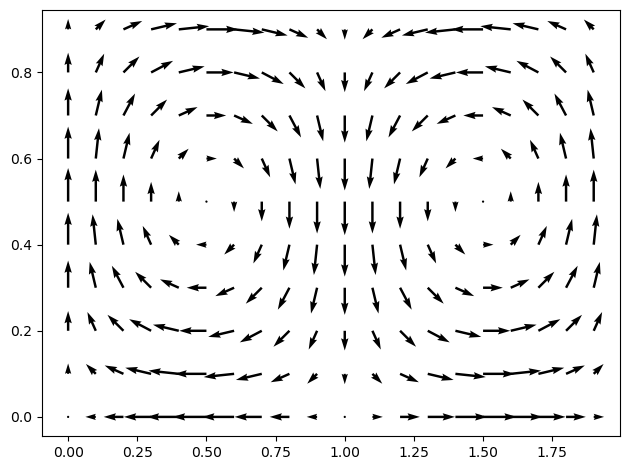

In [3]:
xgrid,ygrid=np.meshgrid(np.arange(0,2,0.1),np.arange(0,1,0.1))

#double_gyre.variables
vars=double_gyre.get_variables(['x_sea_water_velocity', 'y_sea_water_velocity'],time=t0,x=xgrid,y=ygrid)
vars['x_sea_water_velocity'].shape
plt.quiver(xgrid,ygrid,vars['x_sea_water_velocity'],vars['y_sea_water_velocity'])


In [4]:
# Forward run

ofwd = OceanDrift(loglevel=20)
ofwd.set_config('environment:fallback:land_binary_mask', 0)
ofwd.set_config('drift:advection_scheme', 'runge-kutta4')
#ofwd.set_config('drift:horizontal_diffusivity', hordiff) 
outfilefwd = 'ofwd.nc'
try:
    os.remove(outfilefwd)
except:
    print(" ")

double_gyre = reader_double_gyre.Reader(epsilon=.25, omega=0.628, A=0.1)
#print (double_gyre)

ofwd.add_reader(double_gyre)

ofwd.seed_elements(lons, lats, radius=0, time=t0)
ofwd.run(duration=timedelta(seconds=10), time_step=dt, time_step_output=1, outfile=outfilefwd)

lon, lat = ofwd.get_lonlats()
geod = pyproj.Geod(ellps='WGS84')
on = np.ones(lon[:, -1].shape)
dummy1, dummy2, dist2incident = geod.inv(lon[:, -1], lat[:, -1], ilon*on, ilat*on)
hits = np.where(dist2incident<radius)[0]
#hit_start_lons = lon[hits, 0]
#hit_start_lats = lat[hits, 0]
o_hit = opendrift.open(outfilefwd, elements=hits)

of = opendrift.open_xarray(outfilefwd, elements=hits)
density_fwd = of.get_histogram(pixelsize_m=2*radius).isel(time=0).isel(origin_marker=0)
density_fwd = density_fwd.where(density_fwd>0)
n=int(density_fwd.sum().item()) # Number of particles that made it
np.array(density_fwd.sum())
vmax = density_fwd.max()
os.remove(outfilefwd)

13:47:41 INFO    opendrift.models.basemodel:526: OpenDriftSimulation initialised (version 1.10.7)
13:47:41 INFO    opendrift.models.basemodel.environment:219: Adding a dynamical landmask with max. priority based on assumed maximum speed of 1.0 m/s. Adding a customised landmask may be faster...
13:47:44 INFO    opendrift.models.basemodel.environment:246: Fallback values will be used for the following variables which have no readers: 
13:47:44 INFO    opendrift.models.basemodel.environment:249: 	x_wind: 0.000000
13:47:44 INFO    opendrift.models.basemodel.environment:249: 	y_wind: 0.000000
13:47:44 INFO    opendrift.models.basemodel.environment:249: 	upward_sea_water_velocity: 0.000000
13:47:44 INFO    opendrift.models.basemodel.environment:249: 	ocean_vertical_diffusivity: 0.000000
13:47:44 INFO    opendrift.models.basemodel.environment:249: 	sea_surface_wave_significant_height: 0.000000
13:47:44 INFO    opendrift.models.basemodel.environment:249: 	sea_surface_wave_stokes_drift_x_veloci

13:48:07 INFO    opendrift.models.basemodel:1978: 2000-01-01 00:00:04 - step 41 of 100 - 90000 active elements (0 deactivated)
13:48:07 INFO    opendrift.models.basemodel:1978: 2000-01-01 00:00:04.100000 - step 42 of 100 - 90000 active elements (0 deactivated)
13:48:08 INFO    opendrift.models.basemodel:1978: 2000-01-01 00:00:04.200000 - step 43 of 100 - 90000 active elements (0 deactivated)
13:48:08 INFO    opendrift.models.basemodel:1978: 2000-01-01 00:00:04.300000 - step 44 of 100 - 90000 active elements (0 deactivated)
13:48:09 INFO    opendrift.models.basemodel:1978: 2000-01-01 00:00:04.400000 - step 45 of 100 - 90000 active elements (0 deactivated)
13:48:09 INFO    opendrift.models.basemodel:1978: 2000-01-01 00:00:04.500000 - step 46 of 100 - 90000 active elements (0 deactivated)
13:48:10 INFO    opendrift.models.basemodel:1978: 2000-01-01 00:00:04.600000 - step 47 of 100 - 90000 active elements (0 deactivated)
13:48:10 INFO    opendrift.models.basemodel:1978: 2000-01-01 00:00:04

13:48:40 DEBUG   opendrift.config:156: Adding 15 config items from __init__
13:48:40 DEBUG   opendrift.config:166:   Overwriting config item readers:max_number_of_fails
13:48:40 DEBUG   opendrift.config:156: Adding 5 config items from __init__
13:48:40 INFO    opendrift.models.basemodel:526: OpenDriftSimulation initialised (version 1.10.7)
13:48:40 DEBUG   opendrift.config:156: Adding 15 config items from oceandrift
13:48:40 DEBUG   opendrift.config:166:   Overwriting config item seed:z
13:48:40 DEBUG   opendrift.export.io_netcdf:270: Importing from ofwd.nc
13:48:40 DEBUG   opendrift.models.basemodel:1652: No elements to deactivate
13:48:40 DEBUG   opendrift.export.io_netcdf:370: Setting imported config: environment:constant:x_sea_water_velocity -> None
13:48:40 DEBUG   opendrift.export.io_netcdf:370: Setting imported config: environment:fallback:x_sea_water_velocity -> 0
13:48:40 DEBUG   opendrift.export.io_netcdf:370: Setting imported config: environment:constant:y_sea_water_velocity

13:48:40 DEBUG   opendrift.export.io_netcdf:370: Setting imported config: drift:max_age_seconds -> None
13:48:40 DEBUG   opendrift.export.io_netcdf:370: Setting imported config: drift:advection_scheme -> runge-kutta4
13:48:40 DEBUG   opendrift.export.io_netcdf:370: Setting imported config: drift:horizontal_diffusivity -> 0
13:48:40 DEBUG   opendrift.export.io_netcdf:370: Setting imported config: drift:wind_uncertainty -> 0
13:48:40 DEBUG   opendrift.export.io_netcdf:370: Setting imported config: drift:relative_wind -> False
13:48:40 DEBUG   opendrift.export.io_netcdf:370: Setting imported config: drift:deactivate_north_of -> None
13:48:40 DEBUG   opendrift.export.io_netcdf:370: Setting imported config: drift:deactivate_south_of -> None
13:48:40 DEBUG   opendrift.export.io_netcdf:370: Setting imported config: drift:deactivate_east_of -> None
13:48:40 DEBUG   opendrift.export.io_netcdf:370: Setting imported config: drift:deactivate_west_of -> None
13:48:40 DEBUG   opendrift.export.io_net

In [5]:
#hits

In [6]:
#o_hit

13:48:44 DEBUG   opendrift.models.basemodel:2300: Setting up map: corners=[-8.117583878001112e-06, 1.8819353058936064e-05, -5.869279863204333e-06, 2.106765707373259e-05], fast=False, lscale=None


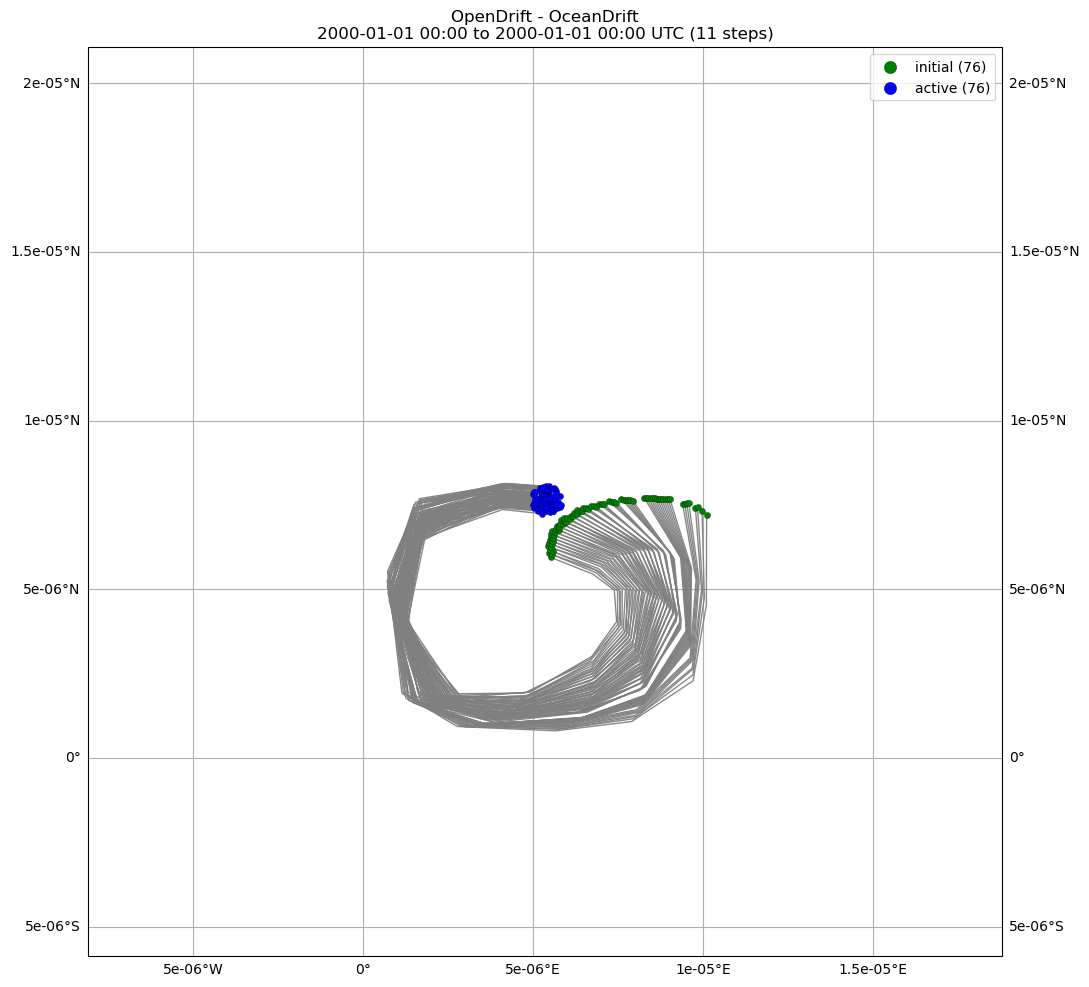

(<GeoAxes: title={'center': 'OpenDrift - OceanDrift\n2000-01-01 00:00 to 2000-01-01 00:00 UTC (11 steps)'}>,
 <Figure size 1100x1100 with 1 Axes>)

In [7]:
hit_start_lons = lon[hits, 10]
hit_start_lats = lat[hits, 10]
o_hit.plot(buffer=0, hide_landmask=True,corners=corners)
#plt.title("Forward run")
#plt.savefig("fwd_doublegyre.pdf")



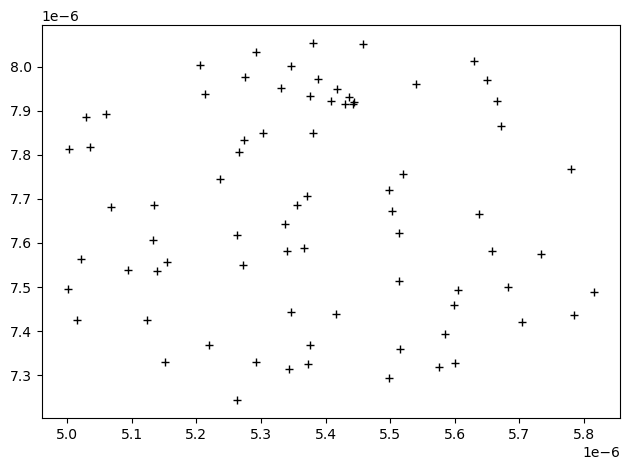

In [8]:
plt.figure()
plt.plot(hit_start_lons,hit_start_lats,'k+')

In [9]:
#plt.savefig("density_fwd_doublegyre.pdf")

In [10]:
#o_hit.plot(background=density_fwd/density_fwd.sum()*100, clabel='Fwd: Probability of origin [%]', text=text, corners=corners, markersize=.5, lalpha=.02, vmin=0, vmax=vmax)



In [11]:
# Reverse run
orev = OceanDrift(loglevel=50)
orev.set_config('environment:fallback:land_binary_mask', 0)
orev.set_config('drift:advection_scheme', 'runge-kutta4')
#orev.set_config('drift:horizontal_diffusivity', hordiff) 
outfile = 'orev.nc'
try:
    os.remove(outfile)
except:
    print(" ")

orev.add_reader(double_gyre)

orev.seed_elements(ilon, ilat, radius=radius, radius_type='uniform', number=n,
                time=t1)
orev.run(duration=timedelta(seconds=10), time_step=-dt, time_step_output=1, outfile=outfile)
revlon, revlat = orev.get_lonlats()

#orev.animation(buffer=0, hide_landmask=True)
#o_hit = opendrift.open(outfilefwd, elements=hits)
#of = opendrift.open_xarray(outfilefwd, elements=hits)

od = opendrift.open_xarray(outfile)
density_rev = od.get_histogram(pixelsize_m=2*radius).isel(time=-1).isel(origin_marker=0)
density_rev = density_rev.where(density_rev>0)
density_rev = density_rev/density_rev.sum()*100
vmax = density_rev.max()
#orev.plot(background=density_backwards, clabel='Probability of origin [%]', text=text, corners=corners, markersize=.5, lalpha=.02, vmin=0, vmax=vmax)

#orev.plot(background=density_backwards, clabel='Probability of origin [%]', text=text, corners=corners, fast=True, markersize=.5, lalpha=.02, vmin=0, vmax=vmax)
os.remove(outfile)

13:48:44 DEBUG   opendrift.models.oceandrift:116: No machine learning correction available.
13:48:44 DEBUG   opendrift.config:156: Adding 48 config items from environment
13:48:44 DEBUG   opendrift.config:156: Adding 5 config items from environment


13:48:45 DEBUG   opendrift.config:156: Adding 15 config items from __init__
13:48:45 DEBUG   opendrift.config:166:   Overwriting config item readers:max_number_of_fails
13:48:45 DEBUG   opendrift.config:156: Adding 5 config items from __init__
13:48:45 INFO    opendrift.models.basemodel:526: OpenDriftSimulation initialised (version 1.10.7)
13:48:45 DEBUG   opendrift.config:156: Adding 15 config items from oceandrift
13:48:45 DEBUG   opendrift.config:166:   Overwriting config item seed:z
13:48:45 DEBUG   opendrift.export.io_netcdf:217: Importing with Xarray from orev.nc
13:48:45 INFO    opendrift:118: Returning <class 'opendrift.models.oceandrift.OceanDrift'> object
13:48:45 INFO    opendrift.models.basemodel:3806: 	calculating for origin_marker 0...


13:48:45 DEBUG   opendrift.models.basemodel:2300: Setting up map: corners=[-8.117583878001112e-06, 1.8819353058936064e-05, -5.869279863204333e-06, 2.106765707373259e-05], fast=False, lscale=None


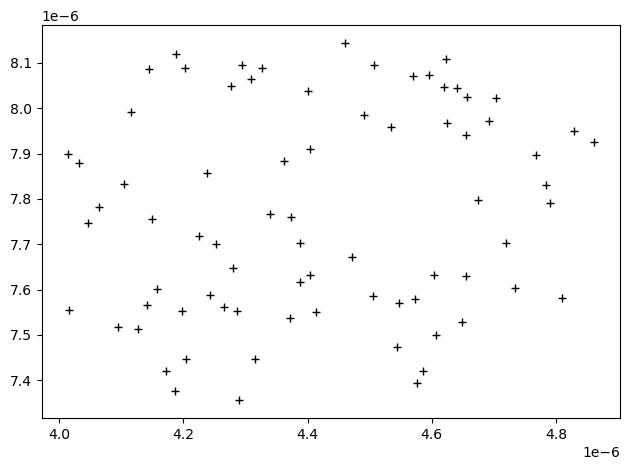

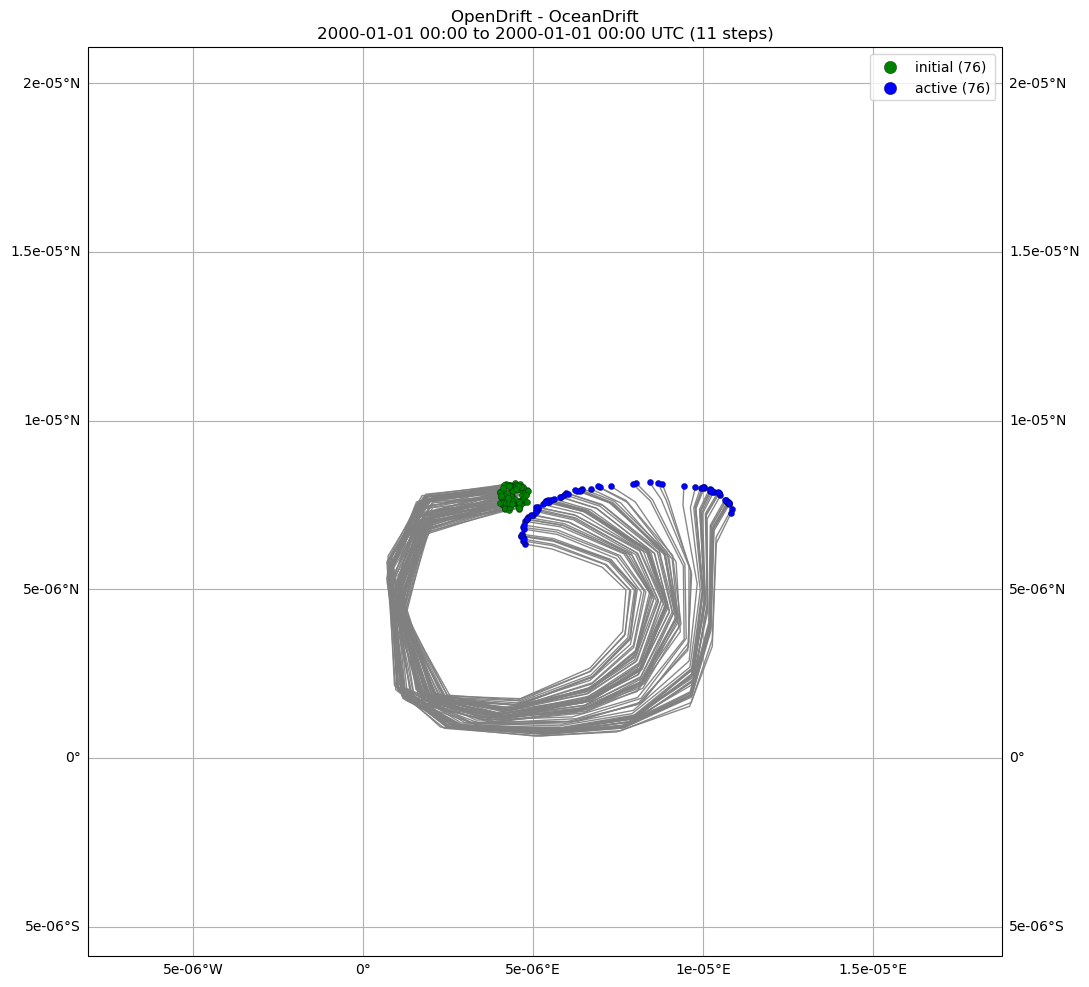

(<GeoAxes: title={'center': 'OpenDrift - OceanDrift\n2000-01-01 00:00 to 2000-01-01 00:00 UTC (11 steps)'}>,
 <Figure size 1100x1100 with 1 Axes>)

In [12]:
plt.plot(revlon[:,0],revlat[:,0],'k+')
orev.plot(buffer=0, hide_landmask=True, corners=corners)


In [13]:
#orev.plot(background=density_rev, clabel='Probability of origin [%]', text=text, corners=corners, markersize=.5, lalpha=.02, vmin=0, vmax=vmax)
